In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, shifted_f, shifted_e, chirp2total, total2chirp, match_h1_h2, get_h

In [2]:
sample_rate = 4096

In [26]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Calculate matches to h1 and h2
        match_1, match_2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(match_h1))
        s_f_matches_2.append(abs(match_h2))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Calculate total quad match of h1 and h2
    s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['h_quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    # Calculate phase of matches
    s = gen_wf(f_low, e, M, fiducials[2], sample_rate, approximant)
    match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
    data['h1_phase'] = np.angle(match_h1)
    data['h2_phase'] = np.angle(match_h2)

    return data

In [4]:
# Makes plot of quad match data
def plot_s_f_quad_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01)):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='dashed', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h2'], ls='dotted', c=f'C0', label=f'h2 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h_quad'], ls='solid', c=f'C0', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')

    # Calculate phase shifts
    s_f_range = f_low - np.min(data['s_f_vals'])
    h1_phase_f = (data['h1_phase']/(2*np.pi))*s_f_range
    h2_phase_f = (data['h2_phase']/(2*np.pi))*s_f_range

    # Which lines to plot
    phase_lines = ['-h1', '-h2', '+h1', '+h2', '-h1,-h2', '+h1,+h2', '-h1,+h2', '+h1,-h2']

    # Loops over each phase line
    for i, line in enumerate(phase_lines):

        # Calculates x_position of phase line
        shifts = line.split(',')
        x_pos = f_low
        for shift in shifts:
            if shift == '-h1':
                x_pos -= h1_phase_f
            elif shift == '-h2':
                x_pos -= h2_phase_f
            elif shift == '+h1':
                x_pos += h1_phase_f
            elif shift == '+h2':
                x_pos += h2_phase_f

        # Cycles x position by 2pi if not on plot
        if x_pos > f_low:
            x_pos -= s_f_range
        elif x_pos < data['s_f_vals'][-1]:
            x_pos += s_f_range

        # Plot line
        ax1.axvline(x_pos, label=line, c=f'C{i+1}')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

In [5]:
start = time.time()
dataslot_0 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 84.14185690879822 seconds


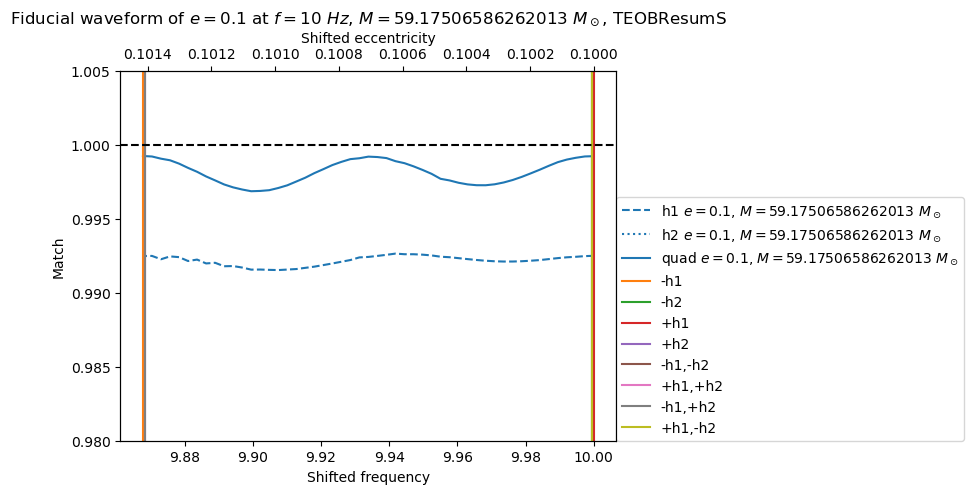

In [19]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), dataslot_0, 10, ylims=(0.98,1.005))

In [7]:
start = time.time()
dataslot_1 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 86.16478610038757 seconds


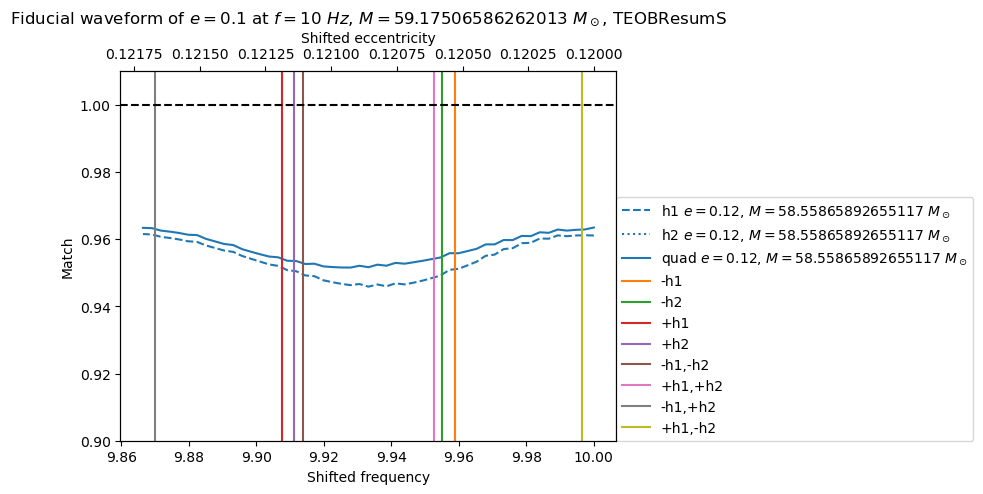

In [8]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_1, 10)

In [9]:
start = time.time()
dataslot_2 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 85.55331707000732 seconds


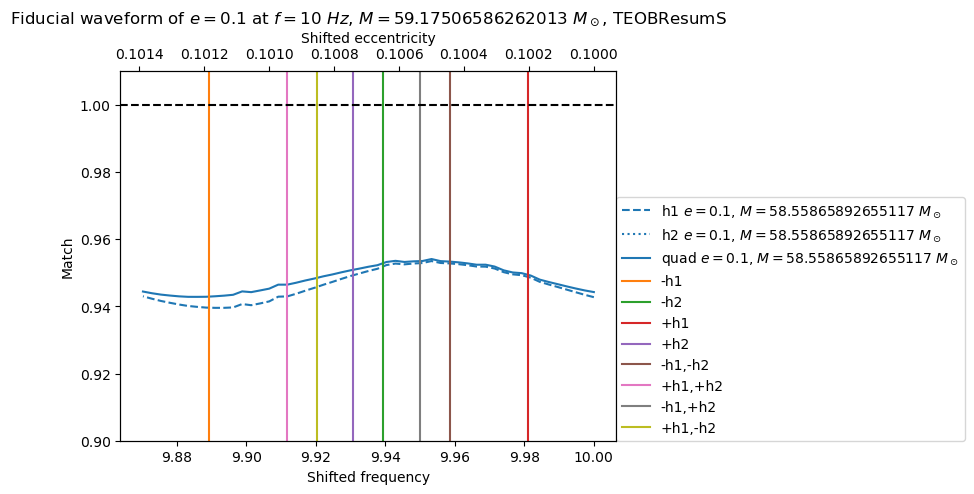

In [10]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), dataslot_2, 10)

In [11]:
start = time.time()
dataslot_3 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 86.90150213241577 seconds


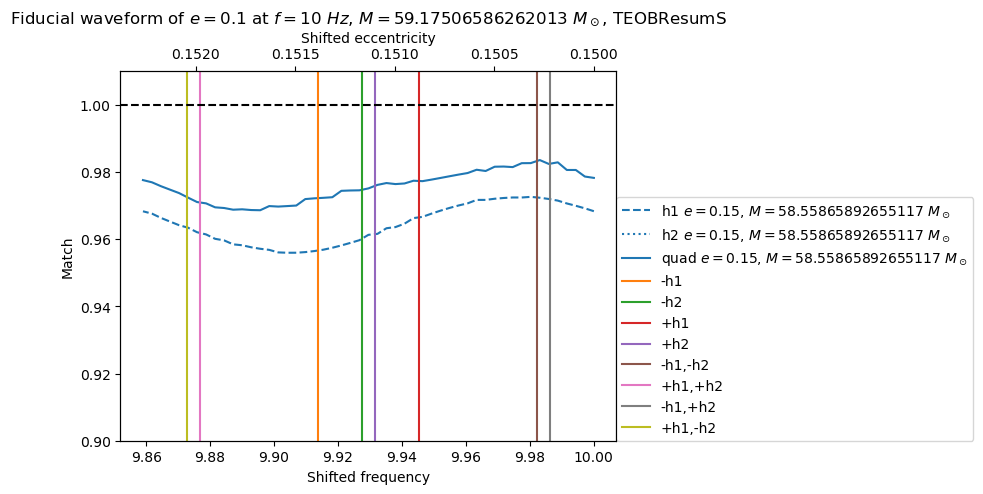

In [12]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(23.75, 2)), dataslot_3, 10)

In [13]:
start = time.time()
dataslot_4 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 81.5327320098877 seconds


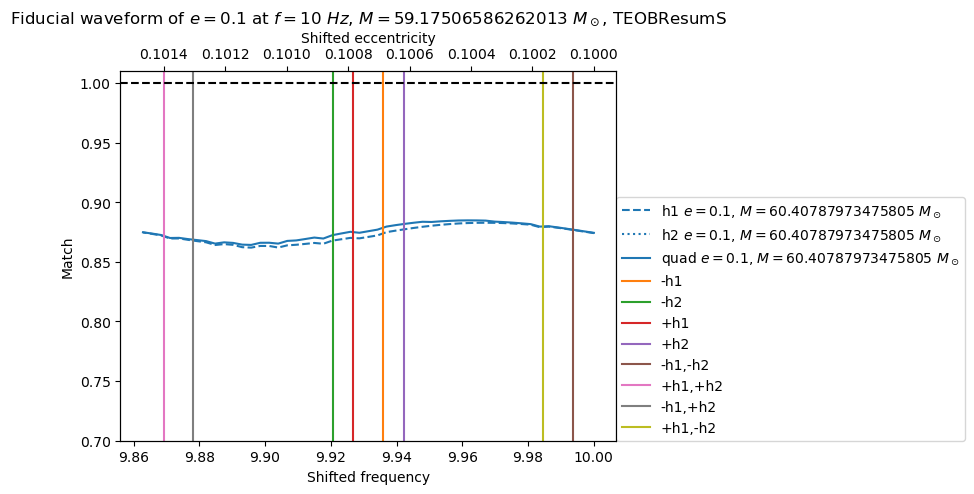

In [14]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_4, 10, ylims=(0.7,1.01))

In [15]:
start = time.time()
dataslot_5 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 19.787253856658936 seconds


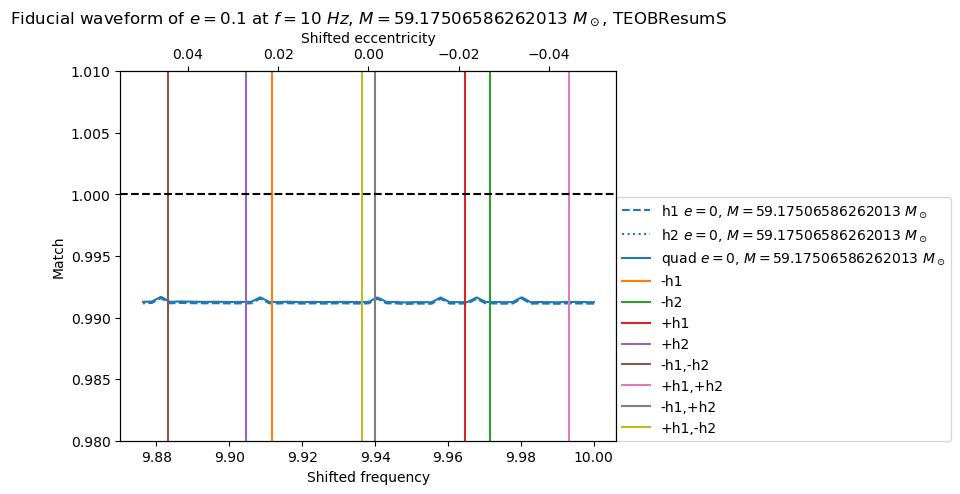

In [20]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0, chirp2total(24, 2)), dataslot_5, 10, ylims=(0.98,1.01))

In [17]:
start = time.time()
dataslot_6 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 84.84264278411865 seconds


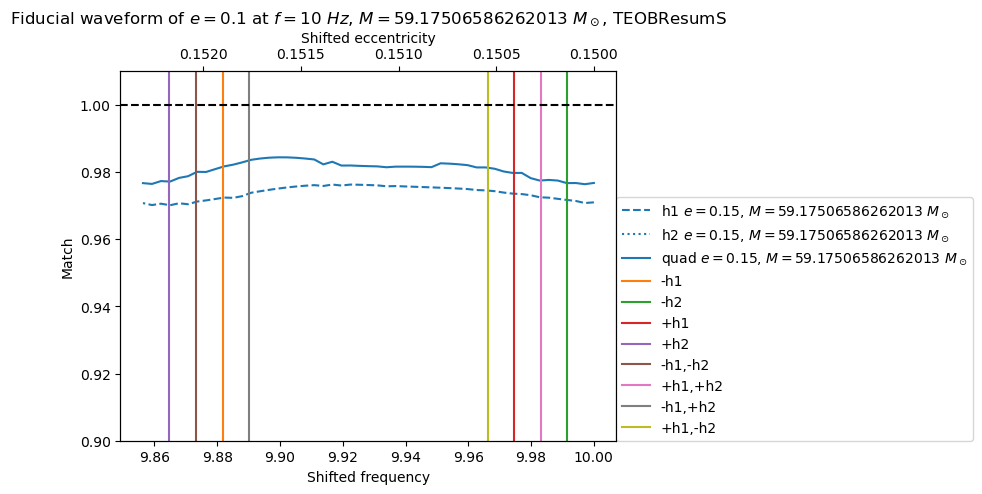

In [18]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(24, 2)), dataslot_6, 10)

In [21]:
start = time.time()
dataslot_7 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 78.8926727771759 seconds


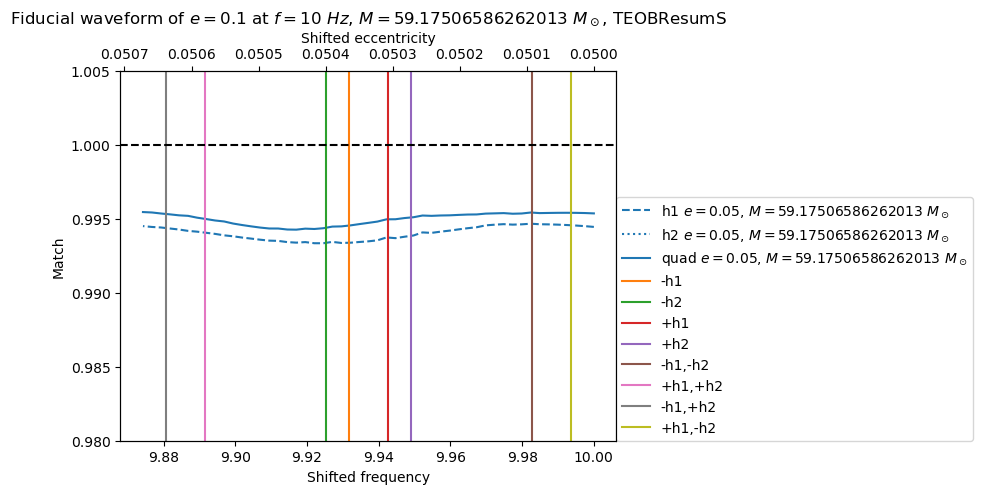

In [25]:
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.05, chirp2total(24, 2)), dataslot_7, 10, ylims=(0.98, 1.005))